In [1]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from pymatgen.io import ase
from pymatgen.analysis.local_env import CrystalNN
import copy
from pymatgen.io import ase
import matplotlib.pyplot as plt
from src.Utility import struc_to_cif
import seaborn as sns
from src.local_features import NMR_local

# Get structures and NMR raw tensors.

### 1. Import data and reprocesses

In [2]:
with open("data/Alnmr.json", "r") as file:
    data = json.load(file)
    print("length of file is {}".format(len(data)))

length of file is 3479


In [3]:
# test if there's any structure dosen't contain the target atom ('Al') and does not contain a structure section
problem_compound = []
for compound in data:
    if "structure" not in compound.keys():
        problem_compound.append(compound)
        continue
    sites = []
    for site in compound["structure"]["sites"]:
        sites.append(site["label"])
    if "Al" not in sites:
        problem_compound.append(compound)
print("num of problem compound:", len(problem_compound))

for compound in problem_compound:
    data.remove(compound)
print("len of none problematic data:", len(data))

num of problem compound: 8
len of none problematic data: 3471


In [4]:
# get rid of the redundances
for i in range(len(data)):
    string = json.dumps(data[i], sort_keys=True)
    data[i] = string
data = list(set(data))

for i in range(len(data)):
    dictionary = json.loads(data[i])
    data[i] = dictionary
print("length of file without redundancy is {}".format(len(data)))

length of file without redundancy is 3022


In [5]:
# get the structure_tensors obj
from src.structure_tensors_gen import get_structure_tensors

structure_tensors = get_structure_tensors(data)
print("length of structure_tensors:", len(structure_tensors))

  1%|          | 22/3022 [00:00<00:27, 110.16it/s]/home/he/anaconda3/envs/27al_ml/lib/python3.8/site-packages/pymatgen/analysis/nmr.py:201: RuntimeWarning: invalid value encountered in double_scalars
  return np.abs((V[1] - V[0]) / V[2])
100%|██████████| 3022/3022 [00:23<00:00, 130.90it/s]

length of structure_tensors: 3022


In [6]:
# Here's what a structure_tensors obj looks like:
structure_tensors[0]["structure"]

Structure Summary
Lattice
    abc : 12.080772894992522 12.080772894992522 12.080772894992522
 angles : 37.407669223114645 153.43550294197073 154.14516204588085
 volume : 343.34521466235503
      A : -11.442773 2.775536 2.702669
      B : 11.442773 -2.775536 2.702669
      C : 11.442773 2.775536 -2.702669
PeriodicSite: Sr (19.3697, 0.1101, 0.0981) [0.0380, 0.8645, 0.8662]
PeriodicSite: Sr (-7.9269, 2.6654, 2.8008) [0.9983, 0.1718, 0.1338]
PeriodicSite: Sr (14.9586, 0.1101, 0.0981) [0.0380, 0.6718, 0.6735]
PeriodicSite: Sr (-3.5158, 2.6654, 2.8008) [0.9983, 0.3645, 0.3265]
PeriodicSite: Y (11.4428, 0.0000, 0.0980) [0.0181, 0.5181, 0.5000]
PeriodicSite: Y (0.0000, 0.0000, 0.0980) [0.0181, 0.0181, 0.0000]
PeriodicSite: Al (5.7214, 0.4114, 2.6463) [0.5637, 0.7396, 0.3241]
PeriodicSite: Al (5.7214, 2.3642, -0.0563) [0.4155, 0.2396, 0.6759]
PeriodicSite: Cu (9.7858, 2.7707, 0.1056) [0.5187, 0.4471, 0.9267]
PeriodicSite: Cu (1.6570, 0.0048, 2.8083) [0.5204, 0.5919, 0.0733]
PeriodicSite: Cu (1.

# Machine learning of CQ on big 27Al database

In [7]:
from src.structure_tensors_modifier import get_n_coord_tensors, append_coord_num, add_oxi_state_by_guess
# Add oxidation state for each structures in structure_tensors obj.
structure_tensors = add_oxi_state_by_guess(structure_tensors)
# Filter structure based on coordination number and append coord num info to "tensors".
structure_tensors_filtered = get_n_coord_tensors(structure_tensors, coord=[4, 5, 6])
structure_tensors_filtered = append_coord_num(structure_tensors_filtered)
len(structure_tensors_filtered)

Add oxidation state by guess.


100%|██████████| 3022/3022 [2:27:13<00:00,  2.92s/it]


Filter structures based coordination number.


  0%|          | 14/3022 [00:00<03:10, 15.78it/s]/home/he/anaconda3/envs/27al_ml/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:3938: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
100%|██████████| 3022/3022 [05:36<00:00,  8.99it/s]


num of structures with [4, 5, 6] coords only: 1862
Append coordination numbers to tensor list.


100%|██████████| 1862/1862 [03:42<00:00,  8.36it/s]


1862

In [9]:
# Add chemical environment info to "Tensor" list
from src.structure_tensors_modifier import append_ce

structure_tensors_filtered = append_ce(structure_tensors_filtered)

Append ChemEnv info to tensor list.

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



100%|██████████| 1862/1862 [26:25<00:00,  1.17it/s]


In [11]:
# Filter structures based on local chemenv.
from src.structure_tensors_modifier import filter_ce

chemenv_filter = filter_ce(structure_tensors_filtered)

Filter structure_tensors based on ChemEnv info.


100%|██████████| 1862/1862 [00:00<00:00, 141671.70it/s]

num of structures with chemenv ['T:4', 'T:5', 'O:6'] only: 1681


In [12]:
# number of outliers
len(chemenv_filter["outliers"])

181

In [47]:
# -*- coding: utf-8 -*-
__author__ = "He Sun"
__email__ = "wushanyun64@gmail.com"

from pymatgen.core.structure import Structure as st
from pymatgen.analysis.local_env import CrystalNN
from pymatgen.analysis.local_env import NearNeighbors
from pymatgen.util.coord import get_angle
from pymatgen.analysis.bond_valence import BVAnalyzer
import numpy as np
import itertools
import statistics
from scipy.spatial import ConvexHull
import warnings
from pprint import pprint
import re
from scipy.spatial import distance_matrix

property_symbol_map={ # map the name of properties to their symbols.
    "Z":"Z",
    "mendeleev_no":"N", #Mendeleev number from definition given by Pettifor, D. G. (1984). 
    "atomic_mass":"M_a",
    "electron_affinity":"EA",
    "X":"X",
    "electronic_structure":"N_v", 
    "atomic_radius_calculated":"r_cal",
    "van_der_waals_radius":"r_vdw",
    # "poissons_ratio":"nu",
    "thermal_conductivity":"lambda",
    "melting_point":"TM",
    "boiling_point":"TB",
    # "critical_temperature":"TC",
    "ionization_energy":"IE1", #First ionization energy
}


class NMR_local:
    """
    A class representing NMR relavent local structure parameters
    such as first order bondlength etc.

    Parameters
    -------------------------
    structure: pymatgen.structure
        The pymatgen structure obj that represent the crystal structure.
    atom: str
        Determine the atom of interest, in this project we care about "Al"
    include_oxidation:boo
        if True, decorate the structure with oxydation charge using BVAnalyzer or "by_guess".
        Very time consuming, but can increase the reliability of neighbours assignment by Voronoi tessellation.
    oxi_method: str
        When include_oxidation==True, choose which method to use. ['BV','guess']
    """

    def __init__(
        self, structure, atom="Al", include_oxidation=False, oxi_method="guess"
    ):
        self._atom = atom
        self._atom_list = self._get_atom_list(structure)

        if include_oxidation:
            if oxi_method == "BV":
                bv = BVAnalyzer()
                try:
                    oxy_structure = bv.get_oxi_state_decorated_structure(structure)
                except Exception:
                    warnings.warn(
                        """
                        Oxidation state can only be assigned for ordered structures.
                        Oxidation state can not be assigned.
                        """
                    )
                    oxy_structure = structure
            elif oxi_method == "guess":
                try:
                    oxy_structure = structure.add_oxidation_state_by_guess()
                except Exception:
                    warnings.warn(
                        """
                        Oxidation state can not be assigned.
                        """
                    )
                    oxy_structure = structure
            else:
                raise ValueError('Value for oxi_method should be "BV" or "guess".')
            self.structure = oxy_structure
            self.first_neighbours = self.get_first_coord()
        else:
            self.structure = structure
            self.first_neighbours = self.get_first_coord()

    @classmethod
    def from_cif(cls, cif, atom="Al", include_oxidation=True):
        """
        Load a cif file into NMR_local.

        Parameter
        -------------------------------
        cif: str
            The address of the cif file for the structure of interest
        include_oxidation:boo
            if True, decorate the structure with oxydation charge using BVAnalyzer
        """
        structure = st.from_file(cif)
        return cls(structure, atom, include_oxidation)

    def print_sites(self):
        """
        print the list of sites in structure

        """
        index = 0
        for i in self.structure.sites:
            pprint((index, i))
            index += 1

    def _get_atom_list(self, structure):
        """
        Get the site index list of the atom of interest ('Al' in our case)

        Parameter
        -------------------
        structure:pymatgen.structure
            The no oxydation state structure used to determine the atom list

        Return
        -------------------
        index_list: list
            A list of the index number for all the atom of interest in the structure.

        """
        index = 0
        index_list = []
        for site in structure:
            if site.specie.symbol == self._atom:
                index_list.append(index)
            index += 1
        return index_list

    def get_first_coord(self):
        """
        Create a 2D table of the first coord atoms for each atom of interest.

        Return
        --------------------
        first_coord_dict: Dataframe
            column name is the index of the atom
        """
        first_coord_dict = {}
        for index in self._atom_list:
            crystalnn = CrystalNN()
            nn_info = crystalnn.get_nn_info(self.structure, index)
            first_coord_dict[index] = nn_info
        return first_coord_dict

    def get_first_bond_length(self):
        """
        create a 2D table of the first order bond length for each atom of interest.

        Return
        -----------------
        first_bond_length_dict: dict
            A dict of first order bond length and relavent statistics (average and std) of the atoms of interest.
        """
        first_coord_dict = self.first_neighbours
        first_bond_length_dict = {}
        for center_index, first_neighbours in first_coord_dict.items():
            distances = []
            for site in first_neighbours:
                vec = site["site"].coords - self.structure[int(center_index)].coords
                distances.append(np.linalg.norm(vec))
            distances_ave = statistics.mean(distances)
            distances_std = statistics.stdev(distances)
            distances_max = max(distances)
            distances_min = min(distances)

            first_bond_length_dict[center_index] = {
                "fbl_values": distances,
                "fbl_average": distances_ave,
                "fbl_std": distances_std,
                "fbl_max":distances_max,
                "fbl_min":distances_min,
                "length": len(distances),
            }
        return first_bond_length_dict

    def get_longitudinal_strain(self):
        """
        Calculate the longitudinal strain of the chosen site. Refer to the following paper for the definition.
        J. Phys. Chem. B 2002, 106, 51, 13176–13185
        As for now, we only consider 4 5 and 6 coordinated site.
        The definition of ideal ployhedraon for different coordination numbers could be find as follows:
        Acta Cryst. (1998). B54, 766-773

        Parameters
        -----------------

        Return
        -----------------
        l_strains_dict: dict
            A dict of the longitudianl strain of the atoms of interest.
        """
        first_coord_dict = self.first_neighbours
        l_strains_dict = {}
        for center_index, first_neighbours in first_coord_dict.items():
            coord_numbers = len(first_neighbours)  # Get the number of coordination

            site_coords = []  # Here we calculate the volume of the Al polyhedron.
            for site in first_neighbours:
                site_coords.append(site["site"].coords)
            volume = ConvexHull(np.asarray(site_coords)).volume

            if coord_numbers == 4:
                r = (1.948557158 * volume) ** (
                    1.0 / 3
                )  # Calculate the bond length for a perfect tetrahedron with the same volume.
                ln_list = []  # store ln(abs(bl/r)) values
                for site in first_neighbours:
                    vec = site["site"].coords - self.structure[int(center_index)].coords
                    bl = np.linalg.norm(vec)  # calculate bond length
                    ln_list.append(abs(bl / r))
                l_strains_dict[center_index] = np.log(ln_list).sum()
            elif coord_numbers == 5:
                # Calculate the bond length for an ideal trigonal bipyramid tetrahedron 
                # with the same volume.
                r = (2.309401077 * volume) ** (1.0 / 3)
                ln_list = []
                for site in first_neighbours:
                    vec = site["site"].coords - self.structure[int(center_index)].coords
                    bl = np.linalg.norm(vec)  # calculate bond length
                    ln_list.append(abs(bl / r))
                l_strains_dict[center_index] = np.log(ln_list).sum()
            elif coord_numbers == 6:
                r = (0.75 * volume) ** (1.0 / 3)
                ln_list = []  # store ln(abs(bl/r)) values
                for site in first_neighbours:
                    vec = site["site"].coords - self.structure[int(center_index)].coords
                    bl = np.linalg.norm(vec)  # calculate bond length
                    ln_list.append(abs(bl / r))
                l_strains_dict[center_index] = np.log(ln_list).sum()
            else:
                warnings.warn(
                    "Coordination number has to be 4, 5 or 6!",
                    category=None,
                    stacklevel=1,
                    source=None,
                )
        return l_strains_dict

    def get_shear_strain(self):
        """
        Calculate the shear strain of the chosen site. Refer to the following paper for the definition.
        J. Phys. Chem. B 2002, 106, 51, 13176–13185
        As for now, we only consider 4, 5 and 6 coordinated site.
        The definition of ideal ployhedraon for different coordination numbers could be find as follows:
        Acta Cryst. (1998). B54, 766-773

        Parameters
        -----------------

        Return
        -----------------
        s_strains_dict: dict
            A dict of the longitudianl strain of the atoms of interest.
        """
        first_coord_dict = self.first_neighbours
        s_strains_dict = {}
        for center_index, first_neighbours in first_coord_dict.items():
            coord_numbers = len(first_neighbours)  # Get the number of coordination

            if coord_numbers == 4:
                angle_0 = 1.911135529  # The bond angle for perfect tetrahedron
                angles_differences = (
                    []
                )  # List of the difference between angle_0 and real bond_angles
                site_combos = itertools.combinations(first_neighbours, 2)
                for combo in site_combos:
                    v1 = (
                        combo[0]["site"].coords
                        - self.structure[int(center_index)].coords
                    )
                    v2 = (
                        combo[1]["site"].coords
                        - self.structure[int(center_index)].coords
                    )
                    angles_differences.append(
                        get_angle(v1, v2, units="radians") - angle_0
                    )
                if len(angles_differences) != 6:
                    warnings.warn(
                        f"""number of angles for tetrahedron should be 6! 
                        Current number is {len(angles_differences)}""",
                        category=None,
                        stacklevel=1,
                        source=None,
                    )
                s_strains_dict[center_index] = abs(np.tan(angles_differences)).sum()

            elif coord_numbers == 5:
                angle_0 = 1.570796327  # The first bond angle of an ideal trigonal bipyramid (90 degree).
                angle_1 = 2.094395102  # The second bond angle of an ideal trigonal bipyramid (120 degree).
                angles_differences = (
                    []
                )  # List of the difference between angle_0 and real bond_angles
                site_combos = itertools.combinations(first_neighbours, 2)
                for combo in site_combos:
                    v1 = (
                        combo[0]["site"].coords
                        - self.structure[int(center_index)].coords
                    )
                    v2 = (
                        combo[1]["site"].coords
                        - self.structure[int(center_index)].coords
                    )
                    angles_differences.append(get_angle(v1, v2, units="radians"))
                angles_differences.sort(reverse=True)
                angles_differences_0 = [
                    x - angle_0 for x in angles_differences[1:4]
                ]  # angle difference on 120 degree angles
                angles_differences_1 = [
                    x - angle_1 for x in angles_differences[4:]
                ]  # angle difference on 90 degree angles
                angles_differences = angles_differences_0 + angles_differences_1
                if len(angles_differences) != 9:
                    warnings.warn(
                        f"""number of angles for octahedron should be 9! 
                        Current number is {len(angles_differences)}""",
                        category=None,
                        stacklevel=1,
                        source=None,
                    )
                s_strains_dict[center_index] = abs(np.tan(angles_differences)).sum()

            elif coord_numbers == 6:
                angle_0 = 1.570796327  # The bond angle for perfect octahedron
                angles_differences = (
                    []
                )  # List of the difference between angle_0 and real bond_angles
                site_combos = itertools.combinations(first_neighbours, 2)
                for combo in site_combos:
                    v1 = (
                        combo[0]["site"].coords
                        - self.structure[int(center_index)].coords
                    )
                    v2 = (
                        combo[1]["site"].coords
                        - self.structure[int(center_index)].coords
                    )
                    angles_differences.append(get_angle(v1, v2, units="radians"))
                angles_differences.sort(reverse=True)
                angles_differences = [
                    x - angle_0 for x in angles_differences[3:]
                ]  # Exclude the 180 degrees.
                if len(angles_differences) != 12:
                    warnings.warn(
                        f"""number of angles for octahedron should be 12! 
                        Current number is {len(angles_differences)}""",
                        category=None,
                        stacklevel=1,
                        source=None,
                    )
                s_strains_dict[center_index] = abs(np.tan(angles_differences)).sum()
            else:
                warnings.warn(
                    "Coordination number has to be 4, 5 or 6!",
                    category=None,
                    stacklevel=1,
                    source=None,
                )
        return s_strains_dict

    def get_DI(self):
        """
        Calculate the distortion index (DI) of the chosen site. 
        Refer to the following paper for the definition.
        J. Phys. Chem. B 2002, 106, 51, 13176–13185

        Parameters
        -----------------

        Return
        -----------------
        di_dict: dict
            A dict of the DI of the atoms of interest.
        """
        first_coord_dict = self.first_neighbours
        di_dict = {}
        for center_index, first_neighbours in first_coord_dict.items():
            coord_numbers = len(first_neighbours)  # Get the number of coordination

            if coord_numbers == 4:
                angle_0 = 1.911135529  # The bond angle for perfect tetrahedron
                angles_differences = (
                    []
                )  # List of the difference between angle_0 and real bond_angles
                site_combos = itertools.combinations(first_neighbours, 2)
                for combo in site_combos:
                    v1 = (
                        combo[0]["site"].coords
                        - self.structure[int(center_index)].coords
                    )
                    v2 = (
                        combo[1]["site"].coords
                        - self.structure[int(center_index)].coords
                    )
                    angles_differences.append(
                        get_angle(v1, v2, units="radians") - angle_0
                    )
                if len(angles_differences) != 6:
                    warnings.warn(
                        f"""number of angles for octahedron should be 6! 
                        Current number is {len(angles_differences)}""",
                        category=None,
                        stacklevel=1,
                        source=None,
                    )
                di_dict[center_index] = abs(np.array(angles_differences)).sum() / (
                    angle_0 * 6
                )
            elif coord_numbers == 5:
                angle_180 = 3.141592653
                angle_90 = angle_180 / 2
                angle_120 = angle_180 * 2 / 3
                angles_differences = []
                site_combos = itertools.combinations(first_neighbours, 2)
                for combo in site_combos:
                    v1 = (
                        combo[0]["site"].coords
                        - self.structure[int(center_index)].coords
                    )
                    v2 = (
                        combo[1]["site"].coords
                        - self.structure[int(center_index)].coords
                    )
                    angles_differences.append(get_angle(v1, v2, units="radians"))
                angles_differences.sort(reverse=True)
                angle_diff_180 = [
                    x - angle_180 for x in angles_differences[0:1]
                ]  # Angle difference for 180 degrees angle
                angle_diff_120 = [
                    x - angle_120 for x in angles_differences[1:4]
                ]  # Angle difference for 120 degrees angle
                angle_diff_90 = [
                    x - angle_90 for x in angles_differences[4:]
                ]  # Angle difference for 90 degrees angle
                angles_differences = angle_diff_180 + angle_diff_120 + angle_diff_90
                if len(angles_differences) != 10:
                    warnings.warn(
                        f"""number of angles for octahedron should be 10! 
                        Current number is {len(angles_differences)}""",
                        category=None,
                        stacklevel=1,
                        source=None,
                    )
                di_dict[center_index] = (
                    abs(np.array(angles_differences)).sum() / 18.8495559
                )
            elif coord_numbers == 6:
                angle_0 = 1.570796327  # The bond angle for perfect tetrahedron
                angles_differences = (
                    []
                )  # List of the difference between angle_0 and real bond_angles
                site_combos = itertools.combinations(first_neighbours, 2)
                for combo in site_combos:
                    v1 = (
                        combo[0]["site"].coords
                        - self.structure[int(center_index)].coords
                    )
                    v2 = (
                        combo[1]["site"].coords
                        - self.structure[int(center_index)].coords
                    )
                    angles_differences.append(get_angle(v1, v2, units="radians"))
                angles_differences.sort(reverse=True)
                angles_differences = [
                    x - angle_0 for x in angles_differences[3:]
                ]  # Exclude the 180 degrees.
                if len(angles_differences) != 12:
                    warnings.warn(
                        f"number of angles for octahedron should be 12! Current number is {len(angles_differences)}",
                        category=None,
                        stacklevel=1,
                        source=None,
                    )
                di_dict[center_index] = abs(np.array(angles_differences)).sum() / (
                    angle_0 * 12
                )
            else:
                warnings.warn(
                    "Coordination number has to be 4, 5 or 6!",
                    category=None,
                    stacklevel=1,
                    source=None,
                )
        return di_dict

    def get_first_bond_angle(self):
        """
        create a 2D table of the first order bond angles for each atom of interest.

        Return
        -----------------
        first_bond_angle_dict: dict
            A dict of first order bond angle of the atom of interest.
        """
        first_coord_dict = self.first_neighbours
        first_bond_angle_dict = {}
        for center_index, first_neighbours in first_coord_dict.items():
            angles = []
            site_combos = itertools.combinations(first_neighbours, 2)
            for combo in site_combos:
                v1 = combo[0]["site"].coords - self.structure[int(center_index)].coords
                v2 = combo[1]["site"].coords - self.structure[int(center_index)].coords
                angles.append(get_angle(v1, v2, units="degrees"))
            angles.sort(reverse=True)
            angles_ave = statistics.mean(angles)
            angles_std = statistics.stdev(angles)
            angles_max = max(angles)
            angles_min = min(angles)
            first_bond_angle_dict[center_index] = {
                "fba_values": angles,
                "fba_average": angles_ave,
                "fba_std": angles_std,
                "fba_max":angles_max,
                "fba_min":angles_min,
                "length": len(angles),
            }
        return first_bond_angle_dict

    def get_second_coord(self):
        """
        Create a 2D table of the second coord atoms for each atom of interest.

        Return
        --------------------
        first_coord_dict: Dataframe
            column name is the index of the atom
        """
        second_coord_dict = {}
        for index in self._atom_list:
            crystalnn = CrystalNN()
            all_nn = crystalnn.get_all_nn_info(self.structure)

            nearneighbors = NearNeighbors()
            second_coord_info = nearneighbors._get_nn_shell_info(
                self.structure, all_nn, index, 2
            )
            second_coord_info = sorted(second_coord_info, key=lambda i: i["site_index"])
            second_coord_dict[index] = second_coord_info
        return second_coord_dict

    # def get_matminer_features(self):
    #     feat= MultipleFeaturizer([
    #         BondOrientationalParameter(),
    #     ])
    #     labels=feat.feature_labels()
    #     mt_features_list = []
    #     for index in self._atom_list:
    #         mt_features = feat.featurize(self.structure,index)
    #         mt_features_list.append(dict(zip(labels,mt_features)))

    def get_species_features(self):
        """[summary]
        """
        first_coord_dict = self.first_neighbours
        features_dict = {}
        for center_index, first_neighbours in first_coord_dict.items():

            # polyhedron properties including all the properties of all sites (center included) 
            # in the polyhedron. 
            N = len(first_neighbours)
            ploy_properties = [] 
            neighbour_coords = []
            for neighbour in first_neighbours:
                neighbour_properties = self._get_site_properties(neighbour['site'])
                ploy_properties.append(neighbour_properties)
                neighbour_coords.append(neighbour['site'].coords)
            neighbour_coords = np.array(neighbour_coords)
            ploy_properties = np.array(ploy_properties)
            species_features = self._species_features_calculator(ploy_properties, center_index,neighbour_coords,N)
            features_dict[center_index]=species_features
        return(features_dict)
    
    @staticmethod
    def _get_site_properties(site):
        """
        something here.

        Note:electronic_structure here will be processed into representing the number of valence 
        electrons (N_v).

        Args:
            site ([type]): [description]
        """
        property_list = []
        for k in property_symbol_map:
            if k == "electronic_structure": # Use e struc to get number of valence electrons.
                e_struc = getattr(site.species.elements[0],k)
                prog = re.compile(r'\.[0-9][s,p,d,f,g,h,i]([0-9])')
                N_v = sum(map(int,prog.findall(e_struc)))
                property_list.append(N_v)
            else:
                property_list.append(getattr(site.species.elements[0],k))
        return(property_list)

    def _species_features_calculator(self,properties_matrix, center_index,neighbour_coords,N):
        """[summary]

        Args:
            properties_matrix ([type]): [description]
            structure ([type]): [description]
            center_index ([type]): [description]
        """
        #get statistics of the properties values
        means = properties_matrix.mean(axis=0)
        std = properties_matrix.std(axis=0)
        max_ = properties_matrix.max(axis=0)
        min_ = properties_matrix.min(axis=0)

        #get average deviation of the properties for the polyhedron
        center_site = self.structure[center_index]
        center_coords = self.structure[center_index].coords
        center_properties = self._get_site_properties(center_site)
        properties_dev = (properties_matrix-center_properties).sum(axis=0)*(1/N)
        
        #get average deviation of the properties normalized by r_cn 
        # (distance between center and neighbour)
        r_cn_rev_list = np.reciprocal(np.linalg.norm(neighbour_coords - center_coords,axis=1))
        dev_matrix = (properties_matrix-center_properties)*(1/N)
        properties_dev_r = (dev_matrix.T*r_cn_rev_list).T.sum(axis=0)

        #get alchemical matrix
        #matrix of all properties including center atom
        properties_all = np.vstack([properties_matrix,center_properties])  
        columns = properties_all.shape[1]
        matrix_list = []
        for i in range(columns):
            matrix_list.append(np.outer(properties_all[:, i],properties_all[:, i]))
        coords_all = np.vstack([neighbour_coords,center_coords])
        dis_matrix_rev = np.reciprocal(distance_matrix(coords_all,coords_all))
        #Fill diagonal of reciprocal distance matrix with 1
        np.fill_diagonal(dis_matrix_rev,1) 
        #get the singular values from alchemical matrix 
        alchemical_s = []
        for pm in matrix_list: #pm property matrix
            alchemical_matrix = np.multiply(pm,dis_matrix_rev)
            svd = np.linalg.svd(alchemical_matrix,full_matrices=False)
            alchemical_s.append(svd[1][:5])
        
        # Get a flatened vector of all property features
        statistics_flat = np.hstack([means,std,max_,min_])
        alchemical_s_flat = np.array(alchemical_s).flatten()
        properties_dev_flat = np.hstack([properties_dev,properties_dev_r])
        result = np.hstack([statistics_flat,properties_dev_flat,alchemical_s_flat])
        return(result)

In [48]:
# from src.local_features import NMR_local
import pandas as pd

def zip_nmr_structure(struc_tensor):
    """
    Combine the NMR values and structural parameters into one table.
    """
    table = pd.DataFrame()
    n = 0
    error_list = []
    error_message = []
    for sample in tqdm(struc_tensor):
        try:
            NMR_struc = NMR_local(sample["structure"])
            first_bond_length = pd.DataFrame.from_dict(
                NMR_struc.get_first_bond_length(), orient="index"
            )
            first_bond_angle = pd.DataFrame.from_dict(
                NMR_struc.get_first_bond_angle(), orient="index"
            )
            l_strain = pd.DataFrame.from_dict(
                NMR_struc.get_longitudinal_strain(),
                orient="index",
                columns=["longitudinal_strain"],
            )
            s_strain = pd.DataFrame.from_dict(
                NMR_struc.get_shear_strain(), orient="index", columns=["shear_strain"]
            )
            di = pd.DataFrame.from_dict(
                NMR_struc.get_DI(), orient="index", columns=["DI"]
            )
            alchemical_features = pd.DataFrame.from_dict(
                NMR_struc.get_species_features(),orient="index"
            )
            nmr = pd.DataFrame(sample["tensors"]).set_index("site_index")
            nmr = nmr.loc[:, "diso":"CQ"]
            nmr["CQ"] = abs(nmr["CQ"])  # Get absolute values for all the CQ
            sample_table = pd.concat(
                [
                    nmr,
                    first_bond_length["fbl_average"],
                    first_bond_length["fbl_std"],
                    first_bond_angle["fba_average"],
                    first_bond_angle["fba_std"],
                    l_strain["longitudinal_strain"],
                    s_strain["shear_strain"],
                    di["DI"],
                    alchemical_features,
                ],
                axis=1,
            )

            if table.empty:
                table = sample_table
            else:
                table = table.append(sample_table)
        except Exception as e:
            error_list.append(n)
            error_message.append(e)
        n += 1
    print(
        f"There are {len(error_list)} structures returns error. Their index are {error_list}"
    )
    print("error_messages:\n", error_message)
    return table

In [49]:
nmr_struc_data = zip_nmr_structure(chemenv_filter["filtered"])

  0%|          | 0/1681 [00:00<?, ?it/s]/tmp/ipykernel_919/3982881166.py:640: RuntimeWarning: divide by zero encountered in reciprocal
  dis_matrix_rev = np.reciprocal(distance_matrix(coords_all,coords_all))
100%|██████████| 1681/1681 [04:22<00:00,  6.40it/s]

There are 0 structures returns error. Their index are []
error_messages:
 []


In [50]:
nmr_struc_data

,diso,csa,csa_reduced,etacs,etaQ,CQ,fbl_average,fbl_std,fba_average,fba_std,...,122,123,124,125,126,127,128,129,130,131
6,286.402975,-52.750533,-35.167022,0.581162,0.106821,10.860828,1.788435,0.026813,109.304101,9.051559,...,7.805452e+06,6394.500688,5567.261309,5365.837278,5028.303027,399.858752,126.899146,122.308051,115.603620,12.965549
7,286.417982,-52.960216,-35.306811,0.644648,0.106797,10.860119,1.788436,0.026813,109.304098,9.051526,...,7.805452e+06,6394.505526,5567.261310,5365.837258,5028.305942,399.858664,126.899146,122.308050,115.603698,12.965561
6,270.742758,-39.429747,-26.286498,0.060476,0.332152,6.457873,1.760880,0.021267,109.355253,4.162908,...,7.805771e+06,6176.967297,5362.106061,5290.812577,5206.775931,402.651543,123.167105,120.653617,118.723619,12.439235
7,270.674618,-39.420129,-26.280086,0.077063,0.346567,6.418334,1.760893,0.021276,109.354104,4.194691,...,7.805771e+06,6177.147547,5363.374964,5291.881090,5204.412306,402.655729,123.203513,120.680772,118.655126,12.439978
8,270.663115,-39.404305,-26.269537,0.076705,0.346489,6.418599,1.760893,0.021276,109.354104,4.194691,...,7.805771e+06,6177.147547,5363.374964,5291.881090,5204.412306,402.655729,123.203513,120.680772,118.655126,12.439978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,231.905999,59.167995,39.445330,0.190249,0.769038,3.212670,1.850040,0.069005,107.611917,27.975342,...,7.807200e+06,7649.377521,6034.304322,5562.068588,5473.619184,467.615571,137.666426,126.878619,124.768595,92.977780
3,231.907821,59.181747,39.454498,0.190363,0.771883,3.217912,1.850074,0.069047,107.611929,27.975358,...,7.807200e+06,7649.586853,6034.483997,5561.996106,5473.624884,467.610335,137.669767,126.877081,124.768711,92.980736
4,231.909802,59.159322,39.439548,0.190437,0.768990,3.212668,1.850040,0.069005,107.611917,27.975342,...,7.807200e+06,7649.377521,6034.304322,5562.068588,5473.619184,467.615571,137.666426,126.878619,124.768595,92.977780
5,231.910247,59.186762,39.457841,0.190442,0.771798,3.218264,1.850074,0.069047,107.611929,27.975358,...,7.807200e+06,7649.586853,6034.483997,5561.996106,5473.624884,467.610335,137.669767,126.877081,124.768711,92.980736


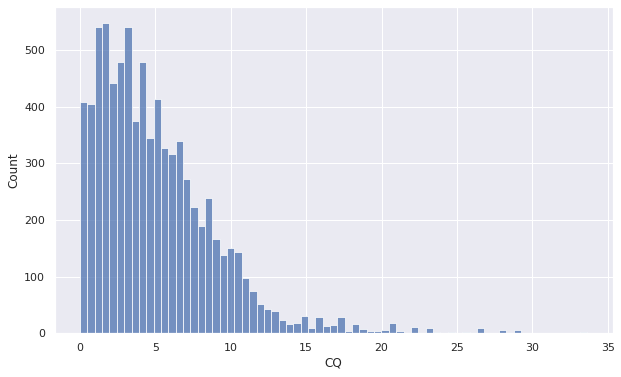

In [51]:
# Get rid of diso outliers
fig, ax = plt.subplots(figsize=[10, 6])
sns.histplot(nmr_struc_data["CQ"], ax=ax)
# plt.xlim((-200,200))
plt.show()

# nmr_struc_data = nmr_struc_data[(nmr_struc_data['diso']>=170) & (nmr_struc_data['diso']<320)]

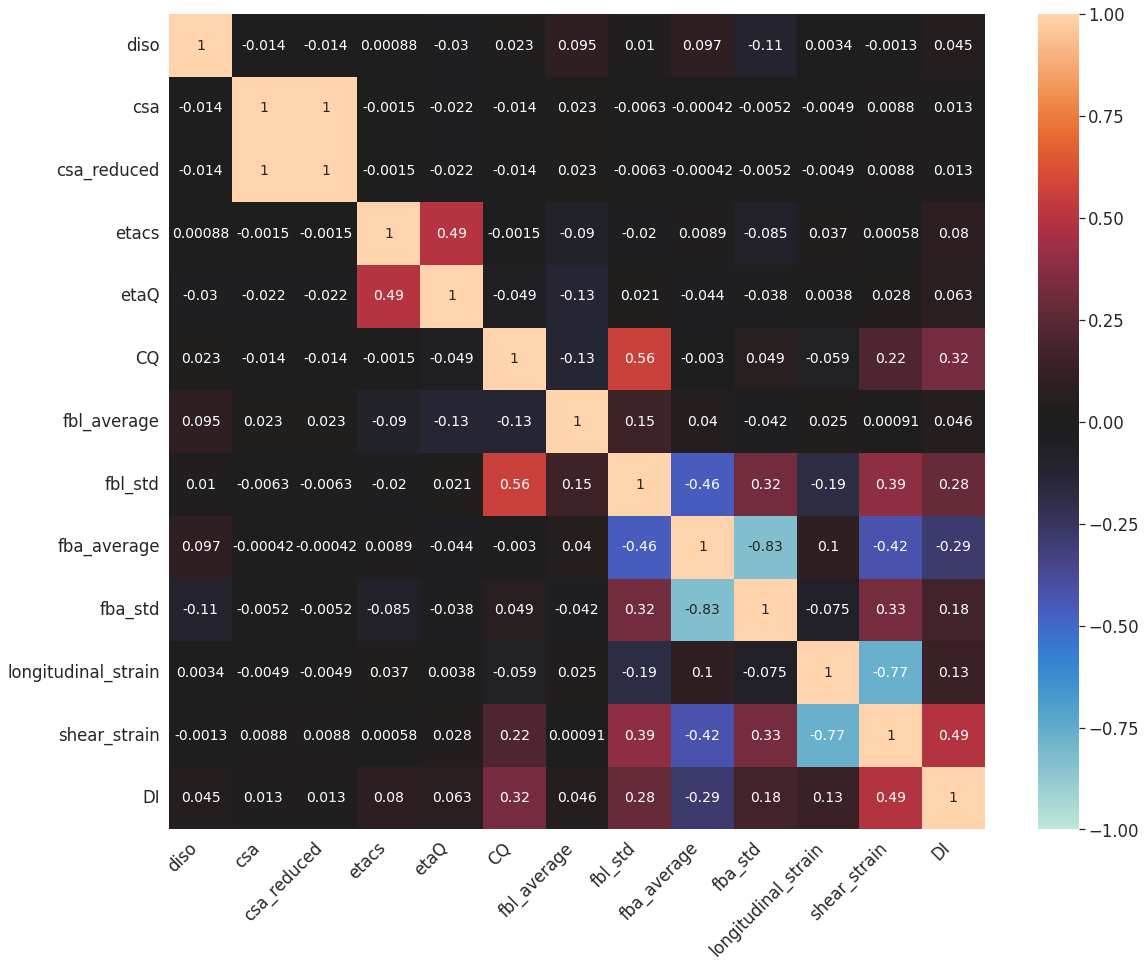

In [53]:
# heat map of structural features
corr = nmr_struc_data.loc[:, :"DI"].corr()

plt.figure(figsize=[19, 15])
heat_map = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    center=0,
    #     cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    annot_kws={"size": 14},
)
heat_map.set_xticklabels(
    heat_map.get_xticklabels(), rotation=45, horizontalalignment="right"
)
sns.set(font_scale=1.5)
plt.savefig("27Al_color_map.png", format="png", bbox_inches="tight")
plt.show()

In [54]:
red_labels = nmr_struc_data[
    (nmr_struc_data["DI"] < 0.001) & (nmr_struc_data["CQ"] > 10)
]

/home/he/anaconda3/envs/27al_ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/he/anaconda3/envs/27al_ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


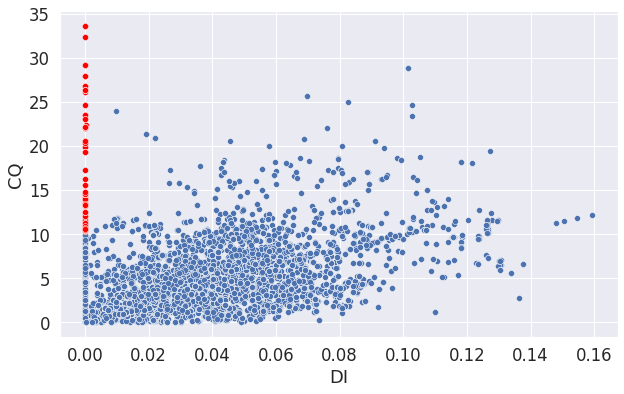

In [55]:
fig, ax = plt.subplots(figsize=[10, 6])
sns.scatterplot(nmr_struc_data["DI"], nmr_struc_data["CQ"], ax=ax)
sns.scatterplot(red_labels["DI"], red_labels["CQ"], ax=ax, color="red")
plt.show()

/home/he/anaconda3/envs/27al_ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/he/anaconda3/envs/27al_ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


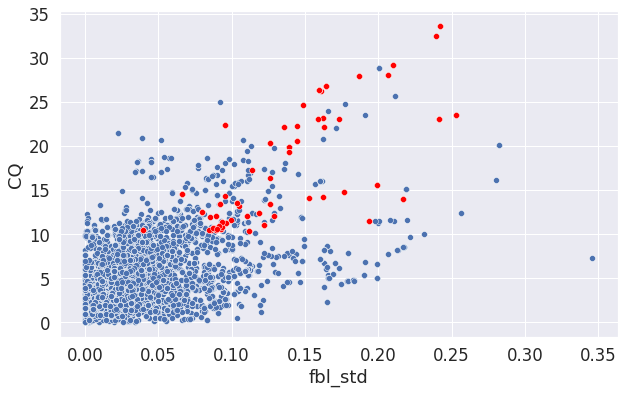

In [56]:
fig, ax = plt.subplots(figsize=[10, 6])
sns.scatterplot(nmr_struc_data["fbl_std"], nmr_struc_data["CQ"], ax=ax)
sns.scatterplot(red_labels["fbl_std"], red_labels["CQ"], ax=ax, color="red")
plt.show()

In [57]:
# normalize the data
normalized_data = (nmr_struc_data - nmr_struc_data.min()) / (
    nmr_struc_data.max() - nmr_struc_data.min()
)
normalized_data

# split y and x
y = normalized_data["CQ"]
x = normalized_data.loc[:, "fbl_average":]

# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=10
)

print(f"Size of train set: {len(X_train)}\nSize of test set: {len(X_test)}")

Size of train set: 6464
Size of test set: 1617


In [58]:
%%time
# Grid Search for Algorithm Tuning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import math

# create and fit a kernel ridge regression model
model = RandomForestRegressor(random_state=10, n_estimators=100)

param = {"n_estimators": randint(low=0, high=200), "max_depth": uniform(10, 100)}

grid = RandomizedSearchCV(
    estimator=model,
    param_distributions=param,
    n_iter=10,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"],
    refit="r2",
    cv=5,
    n_jobs=8,
)
grid.fit(X_train, y_train)
# summarize the results of the grid search

train_r2 = np.sort(grid.cv_results_["mean_test_r2"])[-1]
train_RMSE = math.sqrt(
    -np.sort(grid.cv_results_["mean_test_neg_mean_squared_error"])[-1]
)
train_MAE = -np.sort(grid.cv_results_["mean_test_neg_mean_absolute_error"])[-1]

print(
    "training score: R2 = {}, RMSE = {}, MAE = {}".format(
        train_r2, train_RMSE, train_MAE
    )
)
print(grid.best_estimator_)

training score: R2 = 0.9587312728747903, RMSE = 0.024314364263057678, MAE = 0.010216074148494033
RandomForestRegressor(max_depth=26.18912492629129, n_estimators=40,
                      random_state=10)
CPU times: user 11 s, sys: 1.17 s, total: 12.2 s
Wall time: 3min 53s


test scores: R2 = 0.9716230880588167, RMSE = 0.020113427772642512, MAE = 0.008088444522258462
date and time: 21-09-2021_16-07-56


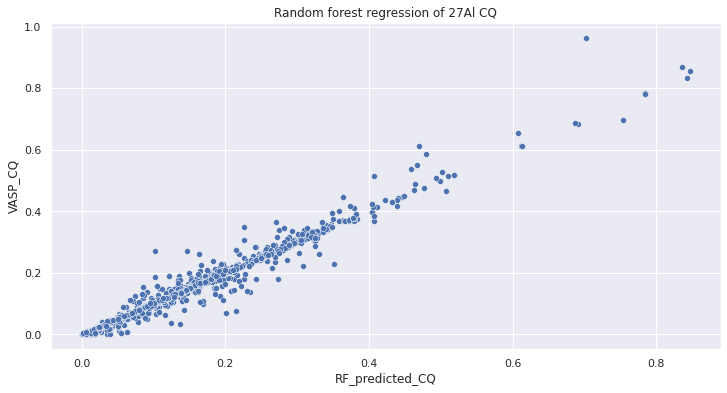

CPU times: user 734 ms, sys: 625 ms, total: 1.36 s
Wall time: 456 ms


In [59]:
%%time
# Predict using kernel ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns

sns.set()
import matplotlib.pyplot as plt
from datetime import datetime


y_rf = grid.predict(X_test)

test_r2 = r2_score(y_test, y_rf)
test_RMSE = math.sqrt(mean_squared_error(y_test, y_rf))
test_MAE = mean_absolute_error(y_test, y_rf)

print("test scores: R2 = {}, RMSE = {}, MAE = {}".format(test_r2, test_RMSE, test_MAE))


# write down the date for png save
predict_result = {}
predict_result["VASP_CQ"] = y_test
predict_result["RF_predicted_CQ"] = y_rf
predict_result = pd.DataFrame(predict_result)

# datetime object containing current date and time
now = datetime.now() 
# dd/mm/YY H:M:S
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
print("date and time:",dt_string)

plt.figure(figsize=[12, 6])
plt.title("Random forest regression of 27Al CQ")
plot = sns.scatterplot(
    x="RF_predicted_CQ",
    y="VASP_CQ",
    data=predict_result[["RF_predicted_CQ", "VASP_CQ"]],
)
plt.savefig('./figures/27Al_RF_testSet_{}.png'.format(dt_string))
plt.show()

In [44]:
import pickle
# save the model to disk
dir_ = "./models/best/"
filename = 'Best_model_09212021.sav'
pickle.dump(grid, open(dir+filename, 'wb'))

## Apply the machine learning model to the benchmarking set

In [ ]:
import os
from pymatgen.core.structure import Structure as st

In [ ]:
# get a list of all structure file name
cif_dir = os.getcwd() + "/27Al_cif_files/"
cif_list = sorted(os.listdir(cif_dir), key=lambda x: int(x.split("_")[0]))
cif_list

In [ ]:
# open the csv file that contains nmr infos
with open("Al Database_033021.csv", "r") as file:
    nmr_data = pd.read_csv(file)
nmr_data = nmr_data[nmr_data["Structure Name"].notna()]

In [ ]:
nmr_data

In [ ]:
# group NMR parameters of sites based on the structure they belong to.
name = "Berlinite"
nmr_data_dict = {}
for row in nmr_data.iterrows():
    v = {
        "diso": row[1]["CASTEP dISO (absolute)"],
        "etaQ": row[1]["CASTEP etaQ"],
        "CQ": row[1]["CASTEP CQ (MHz)"],
        "site_index": int(row[1]["site_index"]),
    }
    if row[1]["Structure Name"] == name:
        nmr_data_dict.setdefault(name, []).append(v)
    else:
        name = row[1]["Structure Name"]
        nmr_data_dict.setdefault(name, []).append(v)
nmr_data_dict["Kyanite"]

In [ ]:
benchmark = []
for cif in cif_list:
    name = cif.split(".")[0].split("_")[1]
    index = cif.split(".")[0].split("_")[0]
    print(index, "_", name)
    structure = st.from_file(os.getcwd() + "/27Al_cif_files/" + cif)
    benchmark.append({"structure": structure, "tensors": nmr_data_dict[name]})

In [ ]:
n_coord_benchmark = get_n_coord_tensors(benchmark)
print(len(n_coord_benchmark))

In [ ]:
al_o_benchmark = get_Al_O_structs(n_coord_benchmark)
print(len(al_o_benchmark))

In [ ]:
nmr_struc_benchmark = zip_nmr_structure(al_o_benchmark)

In [ ]:
nmr_struc_benchmark

### 2. Categorization
1. Based on distribution of diso (outliers)
2. Based on atom species
3. Based on coordication numbers
4. Based on whether 3D and has floating species

1. Outliers on diso

In [ ]:
def getDisoList(structures_tensors):
    diso_list = []
    for structure_tensor in structures_tensors:
        for tensor in structure_tensor["tensors"]:
            diso_list.append(tensor["diso"])
    return diso_list


# view the distribution of diso
diso_list = getDisoList(structures_tensors)

plt.figure()
plt.title("Distribution of diso")
sns.distplot(diso_list)
plt.show()

# determine the upper fence and lowers fence based on theory of box plot
median = np.median(diso_list)
upper_quartile = np.percentile(diso_list, 75)
lower_quartile = np.percentile(diso_list, 25)

iqr = upper_quartile - lower_quartile
upper_outer_fence = upper_quartile + 3 * iqr
lower_outer_fence = lower_quartile - 3 * iqr

print("upper outer fence:", upper_outer_fence, "lower outer fence", lower_outer_fence)

# use the upper and lower fence to group the outliers and inliers
outliers = []
inliers = []
for structure_tensor in structures_tensors:
    lenth = len(structure_tensor["tensors"])
    count = 0
    for tensor in structure_tensor["tensors"]:
        if tensor["diso"] < upper_outer_fence and tensor["diso"] > lower_outer_fence:
            count += 1
    if count == lenth:
        inliers.append(structure_tensor)
    else:
        outliers.append(structure_tensor)
print(len(outliers))
print(len(inliers))

In [ ]:
# get rid of structures with weird elements
high_period_elements = [
    "Cs",
    "Ba",
    "La",
    "Hf",
    "Ta",
    "W",
    "Re",
    "Os",
    "Ir",
    "Pt",
    "Au",
    "Hg",
    "Tl",
    "Pb",
    "Bi",
    "Po",
    "At",
    "Rn" "Fr",
    "Ra",
    "Ac",
    "Rf",
    "Db",
    "Sg",
    "Bh",
    "Hs",
    "Mt",
    "Ds",
    "Rg" "Ce",
    "Pr",
    "Nd",
    "Pm",
    "Sm",
    "Eu",
    "Gd",
    "Tb",
    "Dy",
    "Ho",
    "Er",
    "Tm",
    "Yb",
    "Lu" "Th",
    "Pa",
    "U",
    "Np",
    "Pu",
    "Am",
    "Cm",
    "Bk",
    "Cf",
    "Es",
    "Fm",
    "Md",
    "No",
    "Lr",
]
weird_elements = [
    "La",
    "Ce",
    "Nd",
    "Sm",
    "Er",
    "U",
    "Yb",
    "Tb",
    "Dy",
    "Pr",
    "Tm",
    "Ho",
    "Th",
    "Gd",
    "Eu",
    "Pu",
    "Np",
    "Pa",
    "Pm",
    "Ac",
]
excluded_elements = set(
    #     high_period_elements+
    weird_elements
)
i = 0
struct_with_regular_elements = []
for structure_tensor in inliers:
    compo = get_composition(structure_tensor["structure"])
    if list(set(compo) & excluded_elements) == []:
        struct_with_regular_elements.append(structure_tensor)
inliers = struct_with_regular_elements
print(len(inliers))

In [ ]:
# view the distribution of diso for inliers and outliers
diso_out_list = getDisoList(outliers)
diso_in_list = getDisoList(inliers)

fig, axes = plt.subplots(1, 2, figsize=[12, 6], sharey=True)
sns.distplot(diso_out_list, ax=axes[0])
sns.distplot(diso_in_list, ax=axes[1])
fig.suptitle("Distribution of diso")
axes[0].title.set_text("Outliers")
axes[1].title.set_text("Inliers")
plt.show()

2. atom species

In [ ]:
# Atom Species
def get_species(data):
    structures_tensors_compositon_sorted = {}
    occur = []
    for structure_tensor in data:
        compo = get_composition(structure_tensor["structure"])
        # print(compo)
        occur.extend(compo)
        species = list(set(occur))
        structures_tensors_compositon_sorted.setdefault(str(compo), []).append(
            structure_tensor
        )
    return (occur, species, structures_tensors_compositon_sorted)


occur, species, structures_tensors_compositon_sorted = get_species(inliers)

In [ ]:
# rank the atoms based on occurance
occur_count = {}
for atom in occur:
    occur_count.setdefault(str(atom), []).append(atom)

for k, v in occur_count.items():
    occur_count[k] = len(v)
occur_count_sorted = sorted(occur_count.items(), key=lambda x: x[1], reverse=True)
len(occur_count_sorted)

In [ ]:
def structuresWithFirstNAtoms(N, rank, structures_tensors):
    """
    A function that collect structures with atoms only within the set of first N most popular atoms.

    PARAM:
    N: define the first N most popular atoms to choose from
    rank: atom popularity ranking file (occur_count_sorted)
    structures_tensors: the original structure tensor combination file, use inliers is preferred.
    """
    atom_list = [k[0] for k in rank[:N]]
    print("First {} most popular atoms:".format(N), atom_list)
    structure_tensor_N = []
    for structure_tensor in structures_tensors:
        compo = get_composition(structure_tensor["structure"])
        # print(type(compo))
        if set(compo).issubset(set(atom_list)):
            structure_tensor_N.append(structure_tensor)
    print(
        "Number of structure with only fist N popular atoms:", len(structure_tensor_N)
    )
    return structure_tensor_N

In [ ]:
# composition=[]
# for k,v in structures_tensors_compositon_sorted.items():
#     composition.append((k,len(v)))
# composition=np.array(composition)
# composition = pd.DataFrame(composition.reshape((247,8)))
# composition.columns = ['composition','number of structures','composition','number of structures',
#                        'composition','number of structures','composition','number of structures']
# composition

3. Get only Al-O bonding systems

In [ ]:
import warnings

In [ ]:
warnings.filterwarnings("once")

In [ ]:
from pymatgen.core.periodic_table import Element


def get_Al_O_structs(data):
    """
    Get all the structures whose Al is only bonded to O

    """
    crystalnn = CrystalNN()
    Al_O_struc = []
    data_copy = copy.deepcopy(data)
    for compound in tqdm(data_copy):
        i = 0
        for tensor in compound["tensors"]:
            nn_info = crystalnn.get_nn_info(
                compound["structure"], int(tensor["site_index"])
            )
            neighbours = []
            for site_info in nn_info:
                neighbours.append(site_info["site"].specie)
            if set(neighbours) == {Element("O")}:
                i += 1
        if i == len(compound["tensors"]):
            Al_O_struc.append(compound)
    return Al_O_struc

In [ ]:
Al_O_structs = get_Al_O_structs(inliers)

In [ ]:
len(inliers)

In [ ]:
len(Al_O_structs)

In [ ]:
from StructureToCif import struc_to_cif

struc_to_cif(test[10]["structure"])

4. Coordination number

In [ ]:
def get_Ncoord(data):
    crystalnn = CrystalNN()
    data_copy = copy.deepcopy(data)

    for compound in tqdm(data_copy):
        tensor_Ncoord = []
        for tensor in compound["tensors"]:
            N = crystalnn.get_cn(compound["structure"], int(tensor["site_index"]))
            nn_info = crystalnn.get_nn_info(
                compound["structure"], int(tensor["site_index"])
            )
            tensor["first_shell_atoms"] = nn_info
            tensor_Ncoord.append(tensor)
        compound["{}coord_tensor".format(N)] = tensor_Ncoord
    return data_copy

In [ ]:
structure_tensor_Ncoord = get_Ncoord(inliers)

In [ ]:
structure_tensor_sortbycoord = {}
for N in range(15):
    for compound in structure_tensor_Ncoord:
        if "{}coord_tensor".format(str(N)) in compound.keys():
            if len(compound["tensors"]) == len(
                compound["{}coord_tensor".format(str(N))]
            ):
                structure_tensor_sortbycoord.setdefault(str(N), []).append(compound)

In [ ]:
for k, v in structure_tensor_sortbycoord.items():
    print(k, len(v))

5. Whether 3D and has floating species

In [ ]:
# from dim_filter import is_3D, has_floating_species

# not3D_struct = []
# layered_struct=[]
# for item in tqdm(inliers):
#     structure = item['structure']
#     if not is_3D(structure):
#         not3D_struct.append(item)
#         continue
#     if has_floating_species(structure):
#         layered_struct.append(item)
#         continue

In [ ]:
# print(len(not3D_struct),len(layered_struct))

In [ ]:
# inliers_t = []
# for item in inliers:
#     if item not in not3D_struct+layered_struct:
#         inliers_t.append(item)
# inliers = inliers_t
# len(inliers)

6. Neighbour study

In [ ]:
from pymatgen.core.periodic_table import Element


def get_neighbours(data, tensor_type="tensors"):
    """
    Get neighbours info for each Al site and add the info to "neighbours" tag in tensor dict

    tensor_type: specify the type of tensor to consider here, can be "tensors"(default), or "Ncoord_tensor" (N = 0~14)

    """
    crystalnn = CrystalNN()
    #     data_copy = copy.deepcopy(data)
    for compound in tqdm(data):
        i = 0
        for tensor in compound[tensor_type]:
            nn_info = crystalnn.get_nn_info(
                compound["structure"], int(tensor["site_index"])
            )
            neighbours = []
            for site_info in nn_info:
                neighbours.append(site_info)
            tensor["neighbours"] = neighbours
    return data


def get_neighbour_distance_distribution(data, tensor_type="tensors"):
    distance_list = []
    for compound in tqdm(data):
        for tensor in compound[tensor_type]:
            Al_site_ind = tensor["site_index"]
            for site in tensor["neighbours"]:
                neighbour_site_ind = site["site_index"]
                distance = compound["structure"].get_distance(
                    Al_site_ind, neighbour_site_ind
                )
                distance_list.append(distance)
    return distance_list

In [ ]:
distance_list = get_neighbour_distance_distribution(get_neighbours(Al_O_structs))

In [ ]:
plt.figure(figsize=(15, 10))
plt.xlim(-0.5, 4.5)
# plt.ylim(0,7)
sns.distplot(distance_list, kde=False)

In [ ]:
for k, v in structure_tensor_sortbycoord.items():
    get_neighbours(v, "{}coord_tensor".format(k))

In [ ]:
plt.figure(figsize=(15, 10))
plt.xlim(-0.5, 4.5)
for k, v in structure_tensor_sortbycoord.items():
    distance_list_coordnum = get_neighbour_distance_distribution(
        v, "{}coord_tensor".format(k)
    )
    sns.distplot(
        distance_list_coordnum,
        label="{}coord_tensor".format(k),
        axlabel="Bond distance",
        kde=False,
    )
    plt.legend()

In [ ]:
structure_tensor_sortbycoord_partial = {
    key: structure_tensor_sortbycoord[key] for key in ["4", "5", "6"]
}
plt.figure(figsize=(15, 10))
plt.xlim(-0.5, 4.5)
# plt.ylim(0,7)
for k, v in structure_tensor_sortbycoord_partial.items():
    distance_list_coordnum = get_neighbour_distance_distribution(
        v, "{}coord_tensor".format(k)
    )
    sns.distplot(
        distance_list_coordnum,
        label="{}coord_tensor".format(k),
        axlabel="Bond distance",
        kde=False,
    )
    plt.legend()

7. study of atomic properties

In [ ]:
AtomData

In [ ]:
# get neighbours info for all the inliers
inliers = get_neighbours(inliers)

In [ ]:
type(AtomData.loc["H", ["s-electrons", "d-electrons"]])

In [ ]:
inliers[0]

In [ ]:
def get_atomproperty_discriptor(data, atom_data):
    data_copy = copy.deepcopy(data)
    output_data = []
    nmr_param_data = []
    for compound in tqdm(data_copy):
        for nmr_data in compound["tensors"]:
            if nmr_data["neighbours"] != []:
                nmr_param = nmr_data["CQ"]
                kron_product_sum = np.array([])
                site_param_sum = pd.Series()
                bond_length_list = []
                for site in nmr_data["neighbours"]:

                    site_coord = np.array(
                        [
                            site["site"].x,
                            site["site"].y,
                            site["site"].z,
                        ]
                    )

                    site_name = site["site"].species_string

                    site_param = atom_data.loc[
                        site_name, "standard atomic weight":"polarizability"
                    ]

                    bond_length = compound["structure"].get_distance(
                        site["site_index"], nmr_data["site_index"]
                    )

                    kron_product = np.kron(site_param, site_coord)

                    if kron_product_sum.any() == False:
                        kron_product_sum = kron_product
                    else:
                        kron_product_sum = kron_product_sum + kron_product

                    if site_param_sum.any() == False:
                        site_param_sum = site_param
                    else:
                        site_param_sum = site_param_sum + site_param

                    bond_length_list.append(bond_length)

                #                 print("neighbour!!!!", site_name,kron_product,site_param,site_coord)
                site_param_partial = pd.Series(
                    {  #'standard atomic weight':np.linalg.norm(kron_product_sum[0:3]/site_param_sum['standard atomic weight']),
                        "electronegativity_COM": np.linalg.norm(
                            kron_product_sum[3:6] / site_param_sum["electronegativity"]
                        ),
                        "average_bond_length": sum(bond_length_list)
                        / len(bond_length_list)
                        #'first ionization energy':np.linalg.norm(kron_product_sum[6:9]/site_param_sum['first ionization energy']),
                        #'first electron affinity':np.linalg.norm(kron_product_sum[9:12]/site_param_sum['first electron affinity']),
                        #'polarizability':np.linalg.norm(kron_product_sum[12:15]/site_param_sum['polarizability'])
                    }
                )
                site_param_output = pd.concat([site_param_partial, site_param_sum])
                # print(site_param_output)
                output_data.append(site_param_output)
                nmr_param_data.append(nmr_param)
    return (pd.DataFrame(output_data), pd.DataFrame(nmr_param_data))

In [ ]:
X, y = get_atomproperty_discriptor(inliers, AtomData)

In [ ]:
X

### 3. Get descriptor (SOAP, BPSF...)

1. SOAP

In [ ]:
import soaplite
from soaplite import genBasis
from dscribe.descriptors import SOAP
from itertools import combinations_with_replacement


def getSOAPforStruct(structure_tensor, species, rCut=3, nMax=12, Lmax=9):

    # Get structure and atom coord
    atoms = ase.AseAtomsAdaptor.get_atoms(structure_tensor["structure"])

    # initialize SOAP
    species = species
    rcut = rCut
    nmax = nMax
    lmax = Lmax

    # Setting up the SOAP descriptor
    soap = SOAP(
        species=species,
        periodic=True,
        rcut=rcut,
        nmax=nmax,
        lmax=lmax,
        crossover=True,
        sparse=True,
    )

    coord = []
    for tensor in structure_tensor["tensors"]:
        coord.append(tensor["site_coord"])

    location_dict = {}
    for combo in combinations_with_replacement(species, 2):
        loc = soap.get_location(combo)
        location_dict[combo] = loc

    x = soap.create(atoms, positions=coord)

    # SOAP solution: x
    # print("soap size: ", np.shape(x))
    return (x.tocsr(), location_dict)

In [ ]:
def TensorSOAPcombo(structure_tensor, nmr_key, species):
    x, loc = getSOAPforStruct(structure_tensor, species)
    y = []
    for tensor in structure_tensor["tensors"]:
        y.append([tensor[nmr_key], structure_tensor["structure"], tensor["site_index"]])
    return (x, y, loc)

In [ ]:
import math
from scipy.sparse import coo_matrix, csr_matrix


def SOAPkernel(X, Y):
    numerator = (X).dot(Y.T)[0, 0]
    denominator = math.sqrt(csr_matrix.dot(X, X.T)[0, 0] * csr_matrix.dot(Y, Y.T)[0, 0])
    return (numerator / denominator) ** 2

In [ ]:
def AlchemicalSOAP(X, y, loc):
    with open(
        "/mnt/c/Users/wusha/Desktop/desktop/27Al machine learning/element-encoder/emodes_norm.csv",
        "r",
    ) as file:
        emodes = pd.read_csv(file, index_col=0, header=None)

2. BPSF

In [ ]:
# get gaussian symmetry fnx (BPSF)
from matminer.featurizers.site import GaussianSymmFunc


def getGaussianSymFnx(structure_tensor):
    gaussiansym = GaussianSymmFunc(
        etas_g2=[0.000357, 0.003214, 0.0028569, 0.124980, 1.428426],
        etas_g4=[0.000357, 0.003214, 0.0028569, 0.124980, 1.428426],
        zetas_g4=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
        gammas_g4=[1.0, -1.0],
        cutoff=5.5,
    )

    # gaussiansym.feature_labels()
    structure = structure_tensor["structure"]

    Al_site_idx = []
    for tensor in structure_tensor["tensors"]:
        Al_site_idx.append(tensor["site_index"])

    gaussian_sym = []
    for idx in Al_site_idx:
        gaussian_sym_single = gaussiansym.featurize(structure, idx)
        gaussian_sym.append(gaussian_sym_single)
    return gaussian_sym

In [ ]:
def TensorGaussianCombo(structure_tensor, nmr_key):
    x = getGaussianSymFnx(structure_tensor)
    y = []
    for tensor in structure_tensor["tensors"]:
        y.append([tensor[nmr_key], structure_tensor["structure"]])
    return (x, y)

### 4.Machine learning

1. XY split

In [ ]:
# getXY when choose sparse matrix in soap
from scipy.sparse import vstack
from random import sample


def getXY(structures_tensors, num, descriptor, species):
    # loctaion info for slice the soap vector, None when choose other descriptor
    loc = None

    if descriptor == "soap":
        X = None
    elif descriptor == "gaussian_sym":
        X = []
    y = []

    for structure_tensor in tqdm(sample(structures_tensors, num)):
        if descriptor == "soap":
            soap, nmr_param, loc = TensorSOAPcombo(
                structure_tensor, "CQ", species=species
            )
            if X == None:
                X = soap
            else:
                X = vstack([X, soap])
            y.extend(nmr_param)
        elif descriptor == "gaussian_sym":
            gaussian_sym, nmr_param = TensorGaussianCombo(structure_tensor, "diso")
            X.extend(gaussian_sym)
            y.extend(nmr_param)
        else:
            raise ValueError(
                'descriptor should be choosen between "soap" or "gaussian_sym"!'
            )

    if descriptor == "soap":
        X = X
    else:
        X = np.array(X)
    y = pd.DataFrame(y, columns=["nmr", "structure", "site_index"])

    return (X, y, loc)

In [ ]:
# test different between select fist N most popular structure and random selection of structures with same number of structure

method = "random"
if method == "regular":
    N = 74
    species = [k[0] for k in occur_count_sorted[:N]]
    structure_input = structuresWithFirstNAtoms(N, occur_count_sorted, Al_O_structs)
    X, y, loc = getXY(structure_input, len(structure_input), "soap", species)
if method == "random":
    num_of_struct = 1821
    # This part needs modify later
    N = 84
    species = [k[0] for k in occur_count_sorted[:N]]
    X, y, loc = getXY(inliers, num_of_struct, "soap", species)
print(X.shape, y.shape)

In [ ]:
# test only use saop on local structure (by ajusting rCut)
test_rcut_input = []
for v in [structure_tensor_sortbycoord[key] for key in ["4", "5", "6"]]:
    test_rcut_input += v
print(len(test_rcut_input))

test_rcut_species = get_species(test_rcut_input)[1]
print(len(test_rcut_species))

X, y, loc = getXY(test_rcut_input, len(test_rcut_input), "soap", test_rcut_species)

In [ ]:
# test Al-O only local structures with certain SOAP cutoff distance
Al_O_species = get_species(pd.DataFrame(Al_O_structs)["structure"])[1]
print("number of species in Al_O only structures:", len(Al_O_species))
X, y, loc = getXY(Al_O_structs, len(Al_O_structs), "soap", Al_O_species)

In [ ]:
# $test = pd.DataFrame(X)
test.isna().any().any()

In [ ]:
# introduce the element info
from scipy.sparse import hstack

X_combo = None
for k, v in tqdm(loc.items()):
    ecombo = np.dot(emodes.loc[k[0]], emodes.loc[k[1]])
    #     print(ecombo)
    #     print(X[:,v])
    soap_combo = np.dot(X[:, v], ecombo)
    if X_combo == None:
        X_combo = soap_combo
    else:
        X_combo = hstack([X_combo, soap_combo])

In [ ]:
X = X_combo.tocsr()

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10
)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

2. Dimention reduction

In [ ]:
from LowdimentionScatter import Lowdimention_scatter

In [ ]:
from StructureToCif import struc_to_cif

test = []
for i in inliers:
    structure = i["structure"]
    if str(get_composition(structure)) == "['O', 'Al']":
        test.append(structure)
struc_to_cif(test[3])


PCA

In [ ]:
# for each soap in X_train, get the corresponding species combination
y_compo = []
for structure in y["structure"]:
    y_compo.append(str(get_composition(structure)))
y_compo = np.array(y_compo)

# enumerate the combination list
ziplist = list(zip(np.array(range(len(np.unique(y_compo)))), np.unique(y_compo)))

y_compo_num = []
for compo in y_compo:
    for i, c in ziplist:
        if compo == c:
            y_compo_num.append(i)
y_compo_num = np.array(y_compo_num)
pd.DataFrame(ziplist)

In [ ]:
# y_compo_num=[]
# for compo in y_compo:
#     if "H" in compo:
#         y_compo_num.append(1)
#     else:
#         y_compo_num.append(0)
# y_compo_num=np.array(y_compo_num)

In [ ]:
%%time
from sklearn.decomposition import TruncatedSVD

N = 500

pca = TruncatedSVD(n_components=N)
pca_result = pca.fit_transform(X)

print("PCA done!")

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

pca_train, pca_test, y_train, y_test = train_test_split(
    pca_result, y, test_size=0.2, random_state=23
)
print(pca_train.shape, y_train.shape, pca_test.shape, y_test.shape)

In [ ]:
pca_df = pd.DataFrame()

for n in range(N):
    pca_df["pca{}".format(str(n))] = pca_result[:, n]

print(
    "Variance explained per principal component: {}".format(
        pca.explained_variance_ratio_
    )
)

In [ ]:
import seaborn as sns

sns.set()
import matplotlib.pyplot as plt
from datetime import date

plt.figure(figsize=(10, 12))
plot = sns.scatterplot("pca1", "pca2", data=pca_df)
plt.savefig("27Al_SOAP_PCA_{}.png".format(date.today))
plt.show()

In [ ]:
top_two_comp = pca_df[["pca1", "pca2"]]
Lowdimention_scatter(top_two_comp.values, y_compo_num)

T_SNE

In [ ]:
%%time
from sklearn.manifold import TSNE
import time

time_start = time.time()

fashion_tsne = TSNE(
    perplexity=30, early_exaggeration=12, learning_rate=100
).fit_transform(pca_result)

print("t-SNE done!")

In [ ]:
import seaborn as sns

sns.set()
import matplotlib.pyplot as plt
from datetime import date

tsne_pd = pd.DataFrame(fashion_tsne, columns=["tsne1", "tsne2"])

plt.figure(figsize=(10, 12))
plot = sns.scatterplot("tsne1", "tsne2", data=tsne_pd)
plt.savefig("27Al_SOAP_Tsne_{}.png".format(date.today))
plt.show()

In [ ]:
Lowdimention_scatter(fashion_tsne, y_compo_num)

3. Calculate gram matrix

In [ ]:
# get precomputed gram matrix for X_train and X_test
from Gaussian_Kernel import GaussianKernel

gaussian = GaussianKernel(X_train, X_test, sigma=1)
gram_train = gaussian.GaussianMatrix_train()
gram_test = gaussian.GaussianMatrix_test()

In [ ]:
gram_test.shape

#### Ridge regression

In [ ]:
# Show warnings only once

# import warnings
# warnings.filterwarnings(action='once')

# Grid Search for Algorithm Tuning
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# create and fit a ridge regression model, testing each alpha
alphas = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20, 50, 100]
model = Ridge(normalize=True, copy_X=True)
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), scoring="r2", cv=5)
grid.fit(X_train, y_train)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

In [ ]:
# Predict using kernel ridge
import seaborn as sns

sns.set()
import matplotlib.pyplot as plt

y_rr = grid.predict(X_test)

print("score:{}".format(grid.score(X_test, y_test)))

predict_result = pd.DataFrame(np.array([y_rr, y_test])).transpose()
predict_result.rename(columns={1: "DFT_predict", 0: "RR_predict"}, inplace=True)

plt.figure(figsize=[12, 8])
plt.title("Ridge regression of diso (ppm) on SiO2 data set")
plot = sns.scatterplot(x="RR_predict", y="DFT_predict", data=predict_result)
plt.show()

#### Kernel ridge regression

In [ ]:
%%time
# Grid Search for Algorithm Tuning
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# create and fit a kernel ridge regression model
model = KernelRidge(kernel="precomputed")
param = {
    "alpha": uniform(0, 1),
    #          'gamma':uniform(0,100),
    #          'kernel':['rbf']
}

grid = RandomizedSearchCV(
    estimator=model, param_distributions=param, n_iter=20, scoring="r2", cv=5, n_jobs=8
)
grid.fit(gram_train, y_train["nmr"])
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

In [ ]:
%%time
# Predict using kernel ridge
import seaborn as sns

sns.set()
import matplotlib.pyplot as plt
from datetime import date


y_rr = grid.predict(gram_test)

predict_result = y_test
predict_result["RR_predict"] = y_rr
print("score:{}".format(grid.score(gram_test, y_test["nmr"])))

# write down the date for png save
today = date.today()

plt.figure(figsize=[12, 8])
plt.title("Kernel Ridge regression of diso (ppm)")
plot = sns.scatterplot(
    x="RR_predict", y="nmr", data=predict_result[["RR_predict", "nmr"]]
)
plt.savefig("27Al_krr_testSet_{}.png".format(today))
plt.show()

In [ ]:
from StructureToCif import struc_to_cif

bad_structures = predict_result[
    (predict_result["RR_predict"] < (predict_result["nmr"] - 50))
    | (predict_result["RR_predict"] > (predict_result["nmr"] + 50))
]
bad_structures

In [ ]:
predict_result.head()

In [ ]:
struc_to_cif(predict_result["structure"][651])

In [ ]:
from dim_filter import is_3D, has_floating_species

for structure in bad_structures["structure"]:
    if not is_3D(structure):
        print("not_3D")
    if has_floating_species(structure):
        print("has_floating_species")

#### Random forest

In [ ]:
%%time
# Grid Search for Algorithm Tuning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import math

# create and fit a kernel ridge regression model
model = RandomForestRegressor(random_state=10, n_estimators=100)

param = {"n_estimators": randint(low=0, high=200), "max_depth": uniform(10, 100)}

grid = RandomizedSearchCV(
    estimator=model,
    param_distributions=param,
    n_iter=10,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"],
    refit="r2",
    cv=5,
    n_jobs=8,
)
grid.fit(pca_train, y_train["nmr"])
# summarize the results of the grid search

train_r2 = np.sort(grid.cv_results_["mean_test_r2"])[-1]
train_RMSE = math.sqrt(
    -np.sort(grid.cv_results_["mean_test_neg_mean_squared_error"])[-1]
)
train_MAE = -np.sort(grid.cv_results_["mean_test_neg_mean_absolute_error"])[-1]

print(
    "training score: R2 = {}, RMSE = {}, MAE = {}".format(
        train_r2, train_RMSE, train_MAE
    )
)
print(grid.best_estimator_)

In [ ]:
# feature importance
rand = RandomForestRegressor(n_estimators=100)
rand.fit(X_train, y_train)
feat_labels = list(X_train.columns)
feat_import = list(zip(feat_labels, rand.feature_importances_))
for feature in feat_import:
    print(feature)
# plot bar chart
pd.DataFrame(feat_import).set_index(0).plot(kind="barh")

In [ ]:
%%time
# Predict using kernel ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns

sns.set()
import matplotlib.pyplot as plt
from datetime import date

predict_result = {}
y_rr = grid.predict(pca_test)

test_r2 = r2_score(y_test["nmr"], y_rr)
test_RMSE = math.sqrt(mean_squared_error(y_test["nmr"], y_rr))
test_MAE = mean_absolute_error(y_test["nmr"], y_rr)

print("test scores: R2 = {}, RMSE = {}, MAE = {}".format(test_r2, test_RMSE, test_MAE))


# write down the date for png save
predict_result["nmr"] = y_test["nmr"]
predict_result["RF_predict"] = y_rr
predict_result = pd.DataFrame(predict_result)

today = date.today()

plt.figure(figsize=[12, 8])
plt.title("Random forest regression of diso (ppm)")
plot = sns.scatterplot(
    x="RF_predict", y="nmr", data=predict_result[["RF_predict", "nmr"]]
)
plt.savefig("27Al_RF_testSet_{}.png".format(today))
plt.show()